<a href="https://colab.research.google.com/github/teruyo14/DINO/blob/main/DINO_AttentionMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [ ]:
patch_size = 8
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 217MB/s]


In [ ]:
device = "cuda"

In [ ]:
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

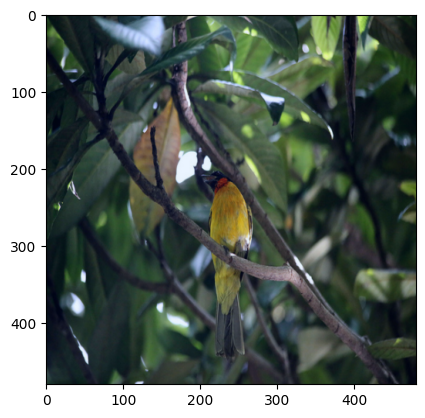

In [ ]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img_npy = Image.open(BytesIO(response.content))
img_npy = img_npy.convert('RGB')
plt.imshow(img_npy)

In [ ]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img_npy)

w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

attentions = model.get_last_selfattention(img.to(device))

print(img.shape)

torch.Size([1, 3, 480, 480])


In [ ]:
nh = attentions.shape[1]

attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

In [ ]:
threshold = 0.6
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]

th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

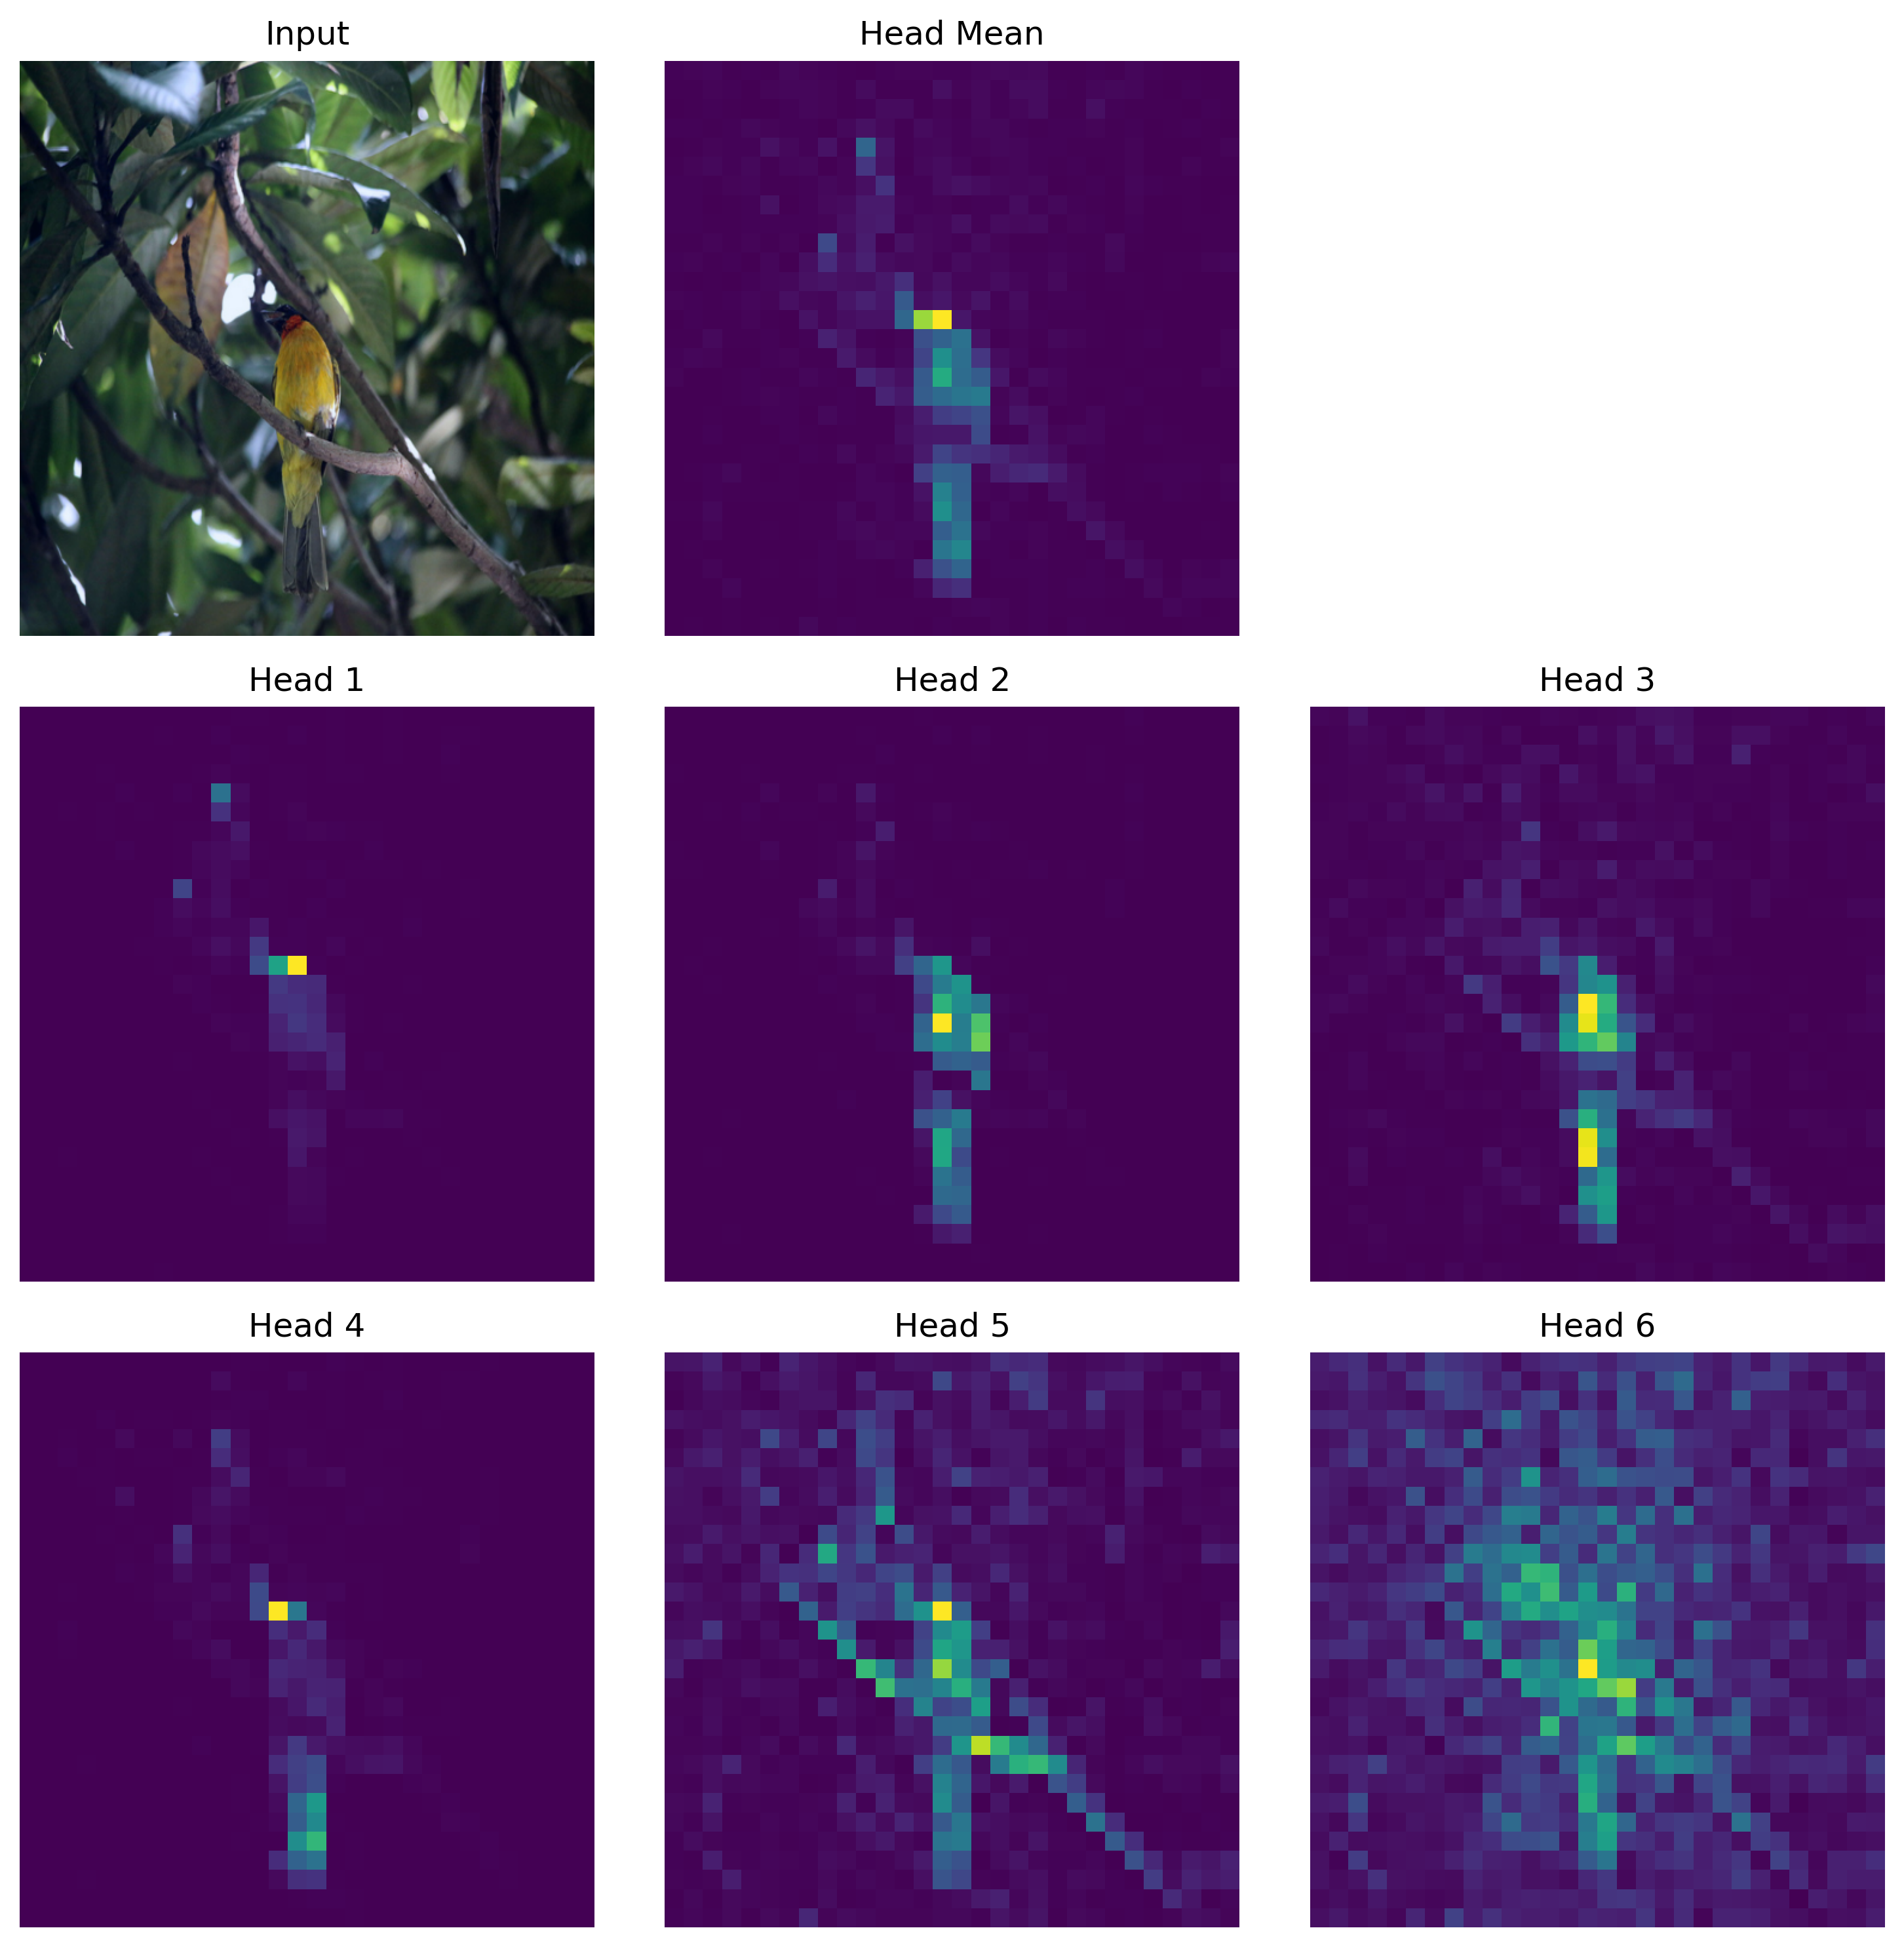

In [ ]:
plt.figure(figsize=(10,10), dpi=300)
plt.subplot(3,3,1)
plt.title("Input")
plt.imshow(img_npy)
plt.axis("off")
for i in range(6):
    plt.subplot(3,3,i+4)
    plt.title("Head "+str(i+1))
    plt.imshow(attentions[i])
    plt.axis("off")

plt.subplot(3,3,2)
plt.title("Head Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()